In [100]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Описание данных

## olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

## olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

## olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [101]:
# Считываем данные
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-nekrasova/Project/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-nekrasova/Project/olist_orders_dataset.csv', 
parse_dates = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-nekrasova/Project/olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных

## Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

Для начала определимся, что можно считать покупкой.
По моему мнению только заказы со статусом *delivered* можно считать покупкой, так как товар уже принят клиентом. Исходя из данных об отмененных заказах (canceled), заказ может быть отменен после передачи заказа в логистическую службу или даже после доставки заказа. Соответесвтенно денежные средсвта будут возвращены клиенту, магазин не заработает, эти заказы уже не считаются за покупку. Cтатус shipped мы не рассматриваем по этой же причине. Заказы со статусом unavailble скорее всего представляют собой заказы, которые после проведения оплаты были отменены и в данный момент они в промежуточном статусе - деньги еще не вернули, но и доставлять товар уже не будут. Поэтому их можно отнести к статусу canceled.

In [102]:
# Посмотрим, какие статусы заказов есть в таблице
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [103]:
# Заказы переданные в службу доставки, но со статусом canceled (отменен)
orders.query("order_status == 'canceled' and order_delivered_carrier_date!='NaT'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
5127,8a9cce19aa49e055f2babb81d5a71c40,f2676ef361959c938b35ecd32321adce,canceled,2018-02-01 10:04:20,2018-02-03 02:52:42,2018-02-05 20:41:28,NaT,2018-02-23
5449,c1049eef89915c6beb3604bf3d6588d7,ed16865bcadcea1a00a928bf418a74bf,canceled,2018-02-05 23:08:11,2018-02-05 23:29:26,2018-02-09 22:13:01,NaT,2018-03-07
...,...,...,...,...,...,...,...,...
94175,c9f06c1229ec7cd4ec9aed55d434b499,fa89053140d09081b3a3a4608a74c083,canceled,2018-02-05 20:26:29,2018-02-05 20:49:48,2018-02-06 19:49:32,NaT,2018-03-01
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08
96300,1def7af24cb7182497acfd953f6dd88b,b35c38c2cd6a72b58cb104154d9782e4,canceled,2017-12-21 09:22:36,2017-12-23 02:12:37,2018-01-30 19:28:55,NaT,2018-02-20
97207,716bcd6dfe99970baf4aed2083136ed8,42715bff8f22b8dc62e5055b1e9fef7e,canceled,2018-02-03 13:37:35,2018-02-03 13:50:26,2018-02-05 19:59:59,NaT,2018-03-01


In [104]:
# Заказы с проставленной датой доставки, но статусом canceled (отменен)
orders.query("order_status == 'canceled' and order_delivered_customer_date!='NaT'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [105]:
# Заказы со статусом unavailable (недоступен)
orders.query('order_status == "unavailable"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [106]:
orders.query('order_status == "unavailable"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

In [107]:
# Создадаим датафрейм только с доставленными заказами
delivered_orders = orders.query("order_status=='delivered'")

In [108]:
# Объединение датафрейма customers и delivered_orders по колонке customer_id
df = customers.merge(delivered_orders, on='customer_id').reset_index(drop=True) 

In [109]:
# Фильтрация и группировка данных
df_one_purchase = df.groupby('customer_unique_id', as_index=False).agg({'order_id': 'count'}).query('order_id==1')

In [110]:
print(f'Количество пользователей, совершивших покупку один раз = {df_one_purchase.customer_unique_id.nunique()}')

Количество пользователей, совершивших покупку один раз = 90557


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Какой заказ можно считать не доставленным? Заказы со статусом delivered сразу исключаем.
В наших данных есть пустые значения в колонке order_delivered_customer_date и заказы со статусом отличным от delivered.

In [111]:
# Создадим датафрейм без заказов со статусом delivered
not_delivered = orders.query("order_status!='delivered'")

In [112]:
# Посмотрим на заказы без даты доставки
not_delivered.query("order_delivered_customer_date.isnull()").order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

Заказы со статусами approved, created, processing, invoiced и shipped не будем рассматривать, так как они еще могут быть доставлены.

In [113]:
# Создадим новую колонку в датафрейме формата год-месяц обещанной даты доставки 
not_delivered['month'] = not_delivered.order_estimated_delivery_date.dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
# Посчитаем среднее число не доставленных заказов в месяц с разбивкой по статусам canceled и unavailable
not_delivered.query("order_delivered_customer_date.isnull() and order_status in ['canceled', 'unavailable']")\
.groupby(['month', 'order_status'], as_index=False).agg({'order_id': 'count'})\
.groupby('order_status', as_index=False).agg({'order_id': 'mean'}).rename(columns={'order_id': 'average_per_month'}).round(1)

,order_status,average_per_month
0,canceled,23.8
1,unavailable,29.0


В итоге таких заказов в месяц в среднем 24 отмененных и 29 недоступных.

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Для решения задачи необходимо объединить два датафрейма - orders и order_items. Берем только заказы со статусом delivered, так как только их мы считаем за покупки.

In [115]:
# Объединяем таблицы
# Пропуски не нужны, поэтому объединяем по совпадающим строкам
items = orders.merge(order_items, on = 'order_id')

In [116]:
items = items.query("order_status == 'delivered'")

In [117]:
# Добавим столбец с названием дня недели, когда был сделан заказ
items['purchase_weekday'] = items['order_purchase_timestamp'].dt.day_name()

In [118]:
items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,purchase_weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [119]:
# Cгруппируем заказы по product_id и дню недели,
# посчитаем число заказов в каждой группе и отсортируем по убыванию числа заказов

# Так как нам нужны дни, в которых заказ покупается чаще всего, то оставляем только первое упоминание каждого product_id
# переименуем колонки согласно их изменениям
items.groupby(['product_id', 'purchase_weekday'], as_index=False)\
.agg({'order_item_id': 'count'})\
.sort_values('order_item_id', ascending=False).drop_duplicates(subset='product_id', keep = 'first')\
.rename(columns={'order_item_id': 'sales'})

,product_id,purchase_weekday,sales
15597,422879e10f46682990de24d770e7f83d,Wednesday,93
35751,99a4788cb24856965c36a24e339b6058,Monday,91
40183,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19711,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13271,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23483,64123627d4116a2bc8284f1bc0a257f3,Saturday,1
23491,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23493,641444946fe3a839d726c32804cd1aff,Tuesday,1
23494,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Для выполнения задания будем использовать датафреймы delivered_orders (из 1-го задания) и customers

In [120]:
# Объединяем таблицы 
customers_buys = delivered_orders.merge(customers, on = 'customer_id')

In [121]:
# Создаем колонку с месяцем покупки
customers_buys['month'] = customers_buys.order_delivered_customer_date.dt.to_period('M')
customers_buys.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02


In [122]:
# Группировка по пользователям и месяцу, считая количество покупок
customers_buys_by_month = customers_buys\
.groupby(['customer_unique_id', 'month'], as_index=False).agg({'order_id': 'count'})\
.rename(columns={'order_id': 'orders'})

In [123]:
# Создаем колонку с количестовм недель в месяце
customers_buys_by_month['weeks_count'] = customers_buys_by_month.month.dt.days_in_month / 7
customers_buys_by_month.head()

,customer_unique_id,month,orders,weeks_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-04,1,4.285714
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11,1,4.285714
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714


In [124]:
# Расчет количества покупок в неделю по месяцам
customers_buys_by_month['orders_by_week'] = customers_buys_by_month.orders/customers_buys_by_month.weeks_count
customers_buys_by_month.head()

,customer_unique_id,month,orders,weeks_count,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-04,1,4.285714,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11,1,4.285714,0.233333
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333


In [125]:
# Сгруппируем по уникальным пользователям и посчитаем среднее количество покупок в неделю по месяцам
orders_by_week = customers_buys_by_month.groupby('customer_unique_id', as_index=False).agg({'orders_by_week': 'mean'})
orders_by_week.head()

,customer_unique_id,orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,0.233333
4,0004aac84e0df4da2b147fca70cf8255,0.233333


## 5. Выполнить когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

In [126]:
# Объеденим два датафрейма delivered_orders и customers
customers_delivered_orders = delivered_orders.merge(customers, on = 'customer_id')[['customer_unique_id', 'order_approved_at']]
customers_delivered_orders.head()

,customer_unique_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29


In [127]:
# Уберем пропущенные значения по столбцу с датой подтверждения оплаты (order_approved_at)
customers_delivered_orders = customers_delivered_orders.dropna(subset = ['order_approved_at'])

In [128]:
# Создаем колонку с месяцем покупки
customers_delivered_orders['month'] = customers_delivered_orders.order_approved_at.dt.to_period('M')
customers_delivered_orders.head()

,customer_unique_id,order_approved_at,month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02


Когортный анализ необходимо построить за 1 полный год. Посмотрим, какой временной промежуток занимают данные

In [129]:
customers_delivered_orders.month.sort_values().unique()

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08']
Length: 23, dtype: period[M]

Подходит только 2017 год.

In [130]:
# Определим для каждого покупателя дату его первой покупки
first_order = customers_delivered_orders.groupby('customer_unique_id', as_index=False)\
.agg({'month': 'min'})\
.rename(columns={'month': 'first_order'})
first_order.head()

,customer_unique_id,first_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [131]:
# Добавим колонку с датой первой покупки к общей таблице
customers_delivered_orders_merged = customers_delivered_orders.merge(first_order, on = 'customer_unique_id')
customers_delivered_orders_merged.head()

,customer_unique_id,order_approved_at,month,first_order
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:43:25,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07,2018-07
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11,2017-11


In [132]:
# Отберем данные с января по декабрь 2017 года
customers_delivered_orders_2017 = customers_delivered_orders_merged.query("'2017-01' <= first_order <= '2017-12' and '2017-01' <= month <= '2017-12'")
customers_delivered_orders_2017.head()

,customer_unique_id,order_approved_at,month,first_order
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:43:25,2017-09,2017-09
4,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11,2017-11
6,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 22:10:13,2017-07,2017-07
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:22:11,2017-05,2017-05


In [133]:
# Формируем когорты
cohorts = customers_delivered_orders_2017.groupby(['first_order','month'])['customer_unique_id'] \
.agg(['nunique', 'count']) \
.rename(columns={'nunique': 'total_customers', 'count': 'total_orders'})
cohorts

total_customers  total_orders
first_order month                                 
2017-01     2017-01              683           714
            2017-02                3             3
            2017-03                2             2
            2017-04                1             1
            2017-05                3             3
...                              ...           ...
2017-10     2017-11               30            32
            2017-12               13            13
2017-11     2017-11             6927          7026
            2017-12               39            41
2017-12     2017-12             5490          5551

[77 rows x 2 columns]

In [134]:
# Добавим порядковое значение периода когорты для каждой когорты.
def cohort_period(df):
     df['cohort_period'] = np.arange(len(df))
     return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(10)

total_customers  total_orders  cohort_period
first_order month                                                
2017-01     2017-01              683           714              0
            2017-02                3             3              1
            2017-03                2             2              2
            2017-04                1             1              3
            2017-05                3             3              4
            2017-06                1             1              5
            2017-07                3             3              6
            2017-08                1             1              7
            2017-09                1             1              8
            2017-11                2             2              9

In [135]:
# Переформатируем таблицу, исключив ненужные столбцы и оставив только номер когорты, дату первого заказа 
# и количество уникальных пользователей.
cohorts = cohorts.reset_index().set_index(['cohort_period', 'first_order'])['total_customers'].unstack(0)
cohorts

cohort_period,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-01,683.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0
2017-02,1612.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,NaN
2017-04,2232.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,NaN,NaN
2017-05,3453.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,NaN,NaN,NaN
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,NaN,NaN,NaN,NaN
2017-07,3709.0,20.0,12.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-08,4081.0,28.0,15.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4025.0,27.0,20.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# Посчитаем Retention Rate = доли возврата от первоначального размера когорты.
retention_rate = cohorts.divide(cohorts[0], axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-01,1.0,0.004392,0.002928,0.001464,0.004392,0.001464,0.004392,0.001464,0.001464,0.002928,0.002928
2017-02,1.0,0.001861,0.002481,0.001861,0.004342,0.001241,0.002481,0.001861,0.000620,0.001861,0.001241
2017-03,1.0,0.004381,0.003584,0.003584,0.003584,0.001593,0.001593,0.003186,0.002788,0.001195,NaN
2017-04,1.0,0.006272,0.002240,0.001792,0.002240,0.002688,0.003584,0.002688,0.003584,NaN,NaN
2017-05,1.0,0.005213,0.004634,0.002896,0.002896,0.003186,0.004054,0.001448,NaN,NaN,NaN
2017-06,1.0,0.004928,0.003942,0.004271,0.002957,0.003614,0.003614,NaN,NaN,NaN,NaN
2017-07,1.0,0.005392,0.003235,0.001887,0.003505,0.001887,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006861,0.003676,0.002695,0.003676,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006708,0.004969,0.003230,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# Визуализируем данные о retention_rate
ur_style = (retention_rate
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

cohort_period,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-01,100.00%,0.44%,0.29%,0.15%,0.44%,0.15%,0.44%,0.15%,0.15%,0.29%,0.29%
2017-02,100.00%,0.19%,0.25%,0.19%,0.43%,0.12%,0.25%,0.19%,0.06%,0.19%,0.12%
2017-03,100.00%,0.44%,0.36%,0.36%,0.36%,0.16%,0.16%,0.32%,0.28%,0.12%,
2017-04,100.00%,0.63%,0.22%,0.18%,0.22%,0.27%,0.36%,0.27%,0.36%,,
2017-05,100.00%,0.52%,0.46%,0.29%,0.29%,0.32%,0.41%,0.14%,,,
2017-06,100.00%,0.49%,0.39%,0.43%,0.30%,0.36%,0.36%,,,,
2017-07,100.00%,0.54%,0.32%,0.19%,0.35%,0.19%,,,,,
2017-08,100.00%,0.69%,0.37%,0.27%,0.37%,,,,,,
2017-09,100.00%,0.67%,0.50%,0.32%,,,,,,,


Теперь довольно легко заметить, что наиболее высокий Retention за третий месяц у когорты пользователей, которые совершили заказ '2017-06' - он составляет 0,43%.

## 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [138]:
# Для постороения RFM-сегментации объеденим 3 датафрейма и сразу удалим пропсуки
df_rfm = delivered_orders[['order_id', 'customer_id', 'order_purchase_timestamp']] \
            .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id') \
            .merge(items[['order_id', 'price']], on='order_id')
df_rfm.dropna()
df_rfm.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90


In [139]:
# Будем считать, что текущая дата - это максимальная дата покупки + 1 день
now = df_rfm.order_purchase_timestamp.max() + timedelta(days=1)
now

Timestamp('2018-08-30 15:00:37')

In [140]:
# создание колонки с датой покупки в формате год-месяц 
df_rfm['purchase_date']=df_rfm['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_rfm.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,price,purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02


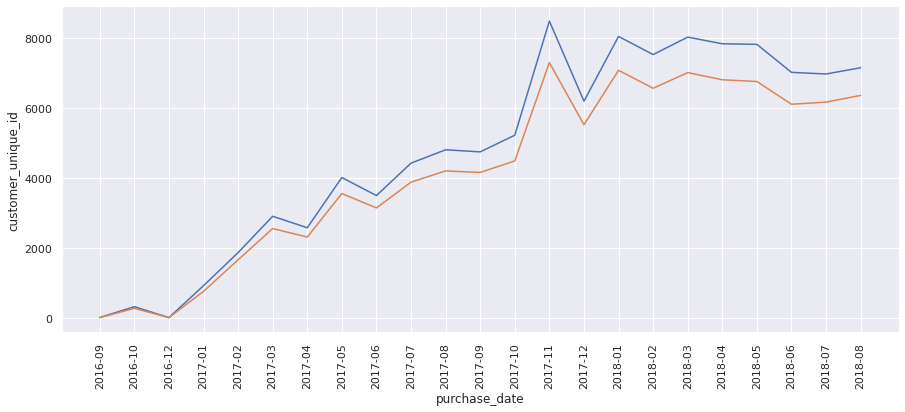

In [141]:
# Чтобы определить период для rfm-анализа - посмотрим на кол-во пользователей и заказов по месяцам
by_month_2=df_rfm.groupby('purchase_date', as_index=False).agg({'customer_unique_id':'count', 'order_id':'nunique'})

plt.figure(figsize=(15,6))
plt.xticks(np.arange(len(by_month_2)), by_month_2['purchase_date'], rotation=90)
sns.lineplot(x='purchase_date', y ='customer_unique_id', data=by_month_2)
sns.lineplot(x='purchase_date', y ='order_id', data=by_month_2)

In [142]:
# В наших данных кол-во клиентов и заказов нарастает до сентября 2018 года. Для анализа RFM обычно используется год. Период с 
# сентября 2017 по август 2018 - наиболее интересен, т.к. на него приходится наибольшее кол-во пользователей и заказов.

Заказы могут содержать несколько строк (по одной строке на товар). Однако нас интересует, сколько раз клиент совершал покупку, а не сколько товаров он купил.

In [143]:
sales = df_rfm.query('purchase_date > "2017-08" and purchase_date < "2018-09"')\
.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False).agg({'price': 'sum'})
sales.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
2,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
3,00054e8431b9d7675808bcb819fb4a32,2017-12-10 11:53:48,635d9ac1680f03288e72ada3a1035803,19.90
4,000576fe39319847cbb9d288c5617fa6,2018-07-04 12:08:27,fda4476abb6307ab3c415b7e6d026526,810.00


In [144]:
# Добавим столбец с количеством дней, прошедших с момента последней покупки
sales['days_since_order'] = sales.order_purchase_timestamp.apply(lambda x: (now - x).days)

Теперь посчитаем все необходимые метрики.

R - время от последней покупки пользователя до текущей даты


F - суммарное количество покупок у пользователя за всё время


M - сумма покупок за всё время

In [145]:
aggr = {
    'days_since_order': lambda x: x.min(), # Recency - агрегация по минимальному количеству дней
    'order_id': 'count', # Frequency - суммарное количество покупок пользователя
    'price': 'sum' # Monetary - общая сумма, потраченная пользователем
}

In [146]:
# Группируем по уникальным пользователям и рассчитываем метрики RFM
rfm = sales.groupby('customer_unique_id', as_index=False) \
            .agg(aggr) \
            .rename(columns={'days_since_order': 'recency', 'order_id': 'frequency', 'price': 'monetary'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00


In [147]:
# Чтобы вывести ранги для данных - необходимо разбить данные на диапазоны. Используем перцентили, отсекающие по 20%
# пользователей
level=[0.2, 0.4, 0.6, 0.8]
quantiles = rfm[['recency', 'frequency', 'monetary']].quantile(level).to_dict()
quantiles

{'recency': {0.2: 71.0, 0.4: 138.0, 0.6: 204.0, 0.8: 275.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.98, 0.8: 179.7}}

In [148]:
# Присвоим ранги для Recency (меньшее значение недавности покупки - лучше)
intervals_R=[0]
for i in range(len(quantiles['recency'])): 
    intervals_R.append(quantiles['recency'][level[i]])
intervals_R.append(rfm.recency.max())
rfm['R']=pd.cut(rfm.recency, intervals_R, labels=['5', '4', '3', '2', '1'])

In [149]:
# % пользователей с одной покупкой
rfm.loc[rfm.frequency==1].frequency.count() / rfm.frequency.count() *100

97.51685191080598

In [150]:
# Обратим внимание, что для Frequency метод перцентилей не подойдет (для всех перцентилей получаем одинаковые значения: 
# у нас 97% пользователей с одной покупкой). В данном случае не хватает информации и товаре, чтобы понимать как правильно
# ранжировать эту метрику. Возможно, у нас очень дорогой товар, который приобретается 1-2 раза, и клиенты с колличеством покупок
# более 5 - это премиум клиенты. А возможно, что сервис так плохо работает, что клиент, купив один раз, больше не возращается.
# Метрика Frequency находится в диапазоне от 1 до 11. Примем во внимание большой объем наблюдений и ранжируем следующим образом:

# [1-3] покупки ранг 1
# (3-5] покупок ранг 2
# (5-7] покупок ранг 3
# (7-9] покупок ранг 4
# (9-11] покупок ранг 5

In [151]:
# Присвоим ранги для Frequency 
intervals_F=[0, 3, 5, 7, 9, 12]
rfm['F']=pd.cut(rfm.frequency, intervals_F, labels=['1', '2', '3', '4', '5'])

In [152]:
# Присвоим ранги для Monetary (чем больше сумма покупок, тем лучше)
intervals_M=[0]
for i in range(len(quantiles['monetary'])): 
    intervals_M.append(quantiles['monetary'][level[i]])
intervals_M.append(rfm.monetary.max())
rfm['M']=pd.cut(rfm.monetary, intervals_M, labels=['1','2','3','4','5'])

rfm.head(3)

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1


In [153]:
# скомбинируем значения R, F, M
rfm=rfm.astype({'R':'string', 'F':'string', 'M':'string'})
rfm['RFM_score'] = rfm['R'] + rfm['F'] + rfm['M']
rfm.head(3)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111


In [154]:
# Для того, чтобы понять в какой сегмент попадают пользователи по метрике Frequency - посмотрим еще раз на частоту встречаемости. 
rfm.F.value_counts()

1    72221
2       21
3        3
5        1
4        1
Name: F, dtype: Int64

In [155]:
# При трех метриках и 5-бальной ранговой системе вариантов комбинаций будет 125. С таким кол-вом комбинаций, конечно, работать
# не удобно. Разобъем пользователей по сегментам, в зависимости от RFM_score. 

# Создадим столбец с рангами, чтобы затем заменить его на названия сегментов
rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# В словарь, с помощью регулярных выражений, занесем правила, по которым будем делить пользователей на сегменты. Как писалось
# выше, сложно оценить по кол-ву покупок к какому сегменту отнести покупателя, не зная что за товар продается. Поэтому в каждый
# сегмент попали покупатели с одной покупкой (т.к. они составляют основную массу покупателей), в некоторых сегментах это ранги
# 1-2, в некоторых 1-5. Сегментирование происходит скорее по метрикам Recency и Monetary. 

segment_map = {
    r'[1-2][1-2][1-2]': 'бездействующие', # покупали давно, мало заказов, маленькая выручка 
    r'[1-2][1-2][3-4]': 'в зоне риска', # покупали давно, мало заказов, средняя выручка 
    r'[1-2][1-5]5': 'не можем потерять', # покупали давно, не мало заказов, высокая выручка 
    r'3[1-2][1-2]': 'спящие', # покупали относительно недавно, мало заказов, маленькая выручка 
    r'3[1-2]3': 'требуют внимание', # покупали относительно недавно, мало заказов, средняя выручка 
    r'[3-4][1-5][4-5]': 'лояльные пользователи', # покупали относительно недавно, не мало заказов, высокая выручка 
    r'4[1-5]1': 'многообещающие', # покупали недавно, не мало заказов, маленькая выручка 
    r'5[1-5]1': 'новые пользователи', # покупали недавно, не мало заказов, маленькая выручка 
    r'[4-5][1-5][2-3]': 'потенциально-лояльные', # покупали недавно, не мало заказов, средняя выручка 
    r'5[1-5][4-5]': 'чемпионы'} # покупали недавно, не мало заказов, высокая выручка 

# заменим ранги на названия сегментов
rfm['segment'] = rfm['segment'].replace(segment_map, regex=True)
rfm.head(3)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,лояльные пользователи
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,многообещающие
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,бездействующие


In [156]:
# посчитаем кол-во пользователей в получившихся сегментах и построим диаграмму

segmentation=rfm.groupby('segment', as_index=False)  \
                .agg({'customer_unique_id':'count'}) \
                .rename(columns={'customer_unique_id':'count_customer'}) \
                .sort_values('count_customer', ascending=False)
segmentation

,segment,count_customer
2,лояльные пользователи,11904
0,бездействующие,11885
6,потенциально-лояльные,11228
1,в зоне риска,11075
7,спящие,6171
9,чемпионы,5814
4,не можем потерять,5686
5,новые пользователи,3100
3,многообещающие,2780
8,требуют внимание,2604


In [157]:
fig = px.treemap(segmentation, path=['segment'], values='count_customer')
fig.update_layout(title="Tree map of Segments", width=700, height=500,)
fig.show()

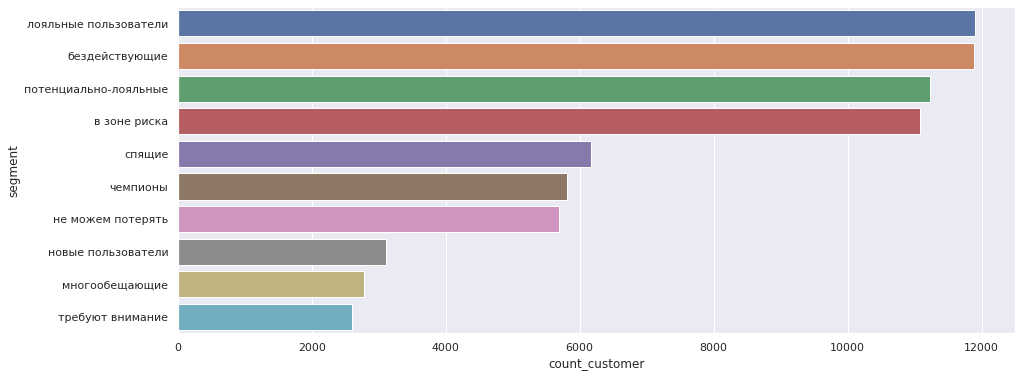

In [158]:
plt.figure(figsize=(15,6))
sns.barplot(x='count_customer', y='segment', data = segmentation)

In [159]:
# Для вывода описания границ интервалов для метрик определим функцию

def description(score):
    r = int(score[0])
    f = int(score[1])
    m = int(score[2])
    rstr = "от " + str(intervals_R[r-1]) + " до " + str(intervals_R[r]) + " дней с даты последней покупки "
    fstr = "от " + str(intervals_F[f-1]) + " до " + str(intervals_F[f]) + " покупок в год "
    mstr = "от " + str(intervals_M[m-1]) + " до " + str(intervals_M[m]) + " руб. в год "
    return ("Границы метрик R: " + rstr + " F: "+ fstr+ " M: "+ mstr)

# создадим столбец с описанием
rfm['description_intervals'] = rfm['RFM_score'].apply(description) 
rfm.head(3)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,segment,description_intervals
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,лояльные пользователи,Границы метрик R: от 204.0 до 275.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 109.98 до 179.7 руб. в год
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,многообещающие,Границы метрик R: от 204.0 до 275.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,бездействующие,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год


In [160]:
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# Описание границ метрик, по которым сотрудники по работе с покупателями смогут:
#     а) понять к какому сегменту относится пользователь
#     б) настроить работу с пользователями, в зависимости от сегмента
    
rfm.groupby(['RFM_score', 'segment', 'description_intervals'], as_index=False)  \
    .agg({'customer_unique_id':'count'})  \
    .rename(columns={'customer_unique_id': 'count_customers'})

,RFM_score,segment,description_intervals,count_customers
0,111,бездействующие,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год,2817
1,112,бездействующие,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 39.9 до 69.9 руб. в год,3094
2,113,в зоне риска,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 69.9 до 109.98 руб. в год,2746
3,114,в зоне риска,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 109.98 до 179.7 руб. в год,2632
4,115,не можем потерять,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 179.7 до 13440.0 руб. в год,2864
5,125,не можем потерять,Границы метрик R: от 0 до 71.0 дней с даты последней покупки F: от 3 до 5 покупок в год M: от 179.7 до 13440.0 руб. в год,2
6,211,бездействующие,Границы метрик R: от 71.0 до 138.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 0 до 39.9 руб. в год,3009
7,212,бездействующие,Границы метрик R: от 71.0 до 138.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 39.9 до 69.9 руб. в год,2965
8,213,в зоне риска,Границы метрик R: от 71.0 до 138.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 69.9 до 109.98 руб. в год,2839
9,214,в зоне риска,Границы метрик R: от 71.0 до 138.0 дней с даты последней покупки F: от 0 до 3 покупок в год M: от 109.98 до 179.7 руб. в год,2858


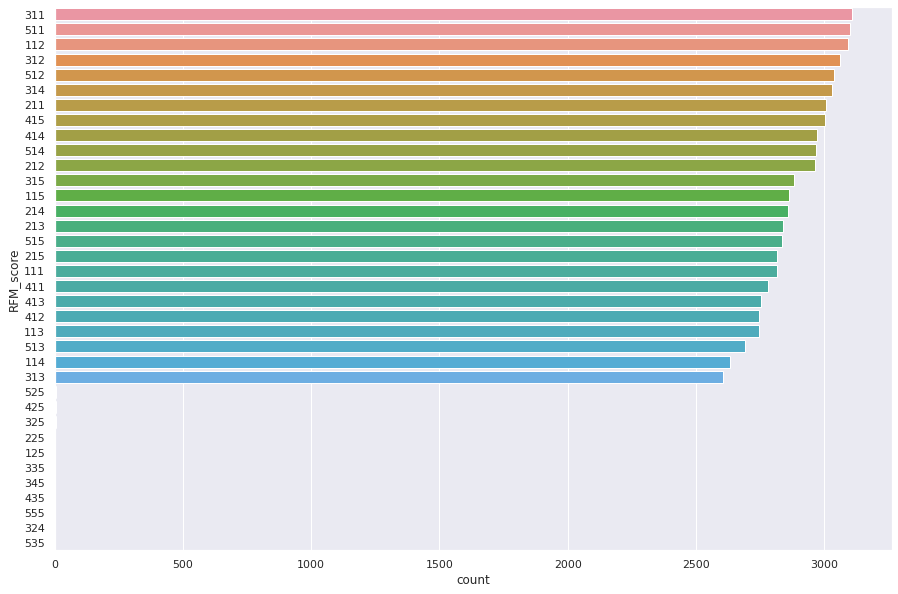

In [161]:
sns.set(rc={"figure.figsize": (15, 10)})
ax = sns.countplot(y=rfm.RFM_score, order=rfm.RFM_score.value_counts().index)

Визуализация показала нам ТОП-5 покупателей:

311 - спящие: пользователи, покупающие редко и мало;

511 - новые пользователи: недавние пользователи, которые купили что-то недорогое;

112 - бездействующие: купили что-то недорогое один раз и не вернулись;

312 - спящие: покупали относительно недавно, мало заказов, небольшая выручка

512 - потенциально-лояльные: покупали недавно, не мало заказов, средняя выручка